In [13]:


import numpy as np
import pandas as pd 


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/face-mask-detection/annotations/maksssksksss737.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss410.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss537.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss295.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss771.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss234.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss620.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss70.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss281.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss393.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss296.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss756.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss260.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss57.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss224.xml
/kaggle/inpu

In [18]:
! ls /kaggle/input/face-mask-detection


annotations  images


In [24]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

ANNOTATIONS_DIR = '/kaggle/input/face-mask-detection/annotations'

IMAGES_DIR = '/kaggle/input/face-mask-detection/images'

def parse_annotations():
    
    data = []
    
    for file in os.listdir(ANNOTATIONS_DIR):
        if file.endswith('.xml'):
            tree = ET.parse(os.path.join(ANNOTATIONS_DIR, file))
            root = tree.getroot()
            filename = root.find('filename').text

            for obj in root.findall('object'):
                label = obj.find('name').text
                bbox = obj.find('bndbox')
                xmin = int(bbox.find('xmin').text)
                ymin = int(bbox.find('ymin').text)
                xmax = int(bbox.find('xmax').text)
                ymax = int(bbox.find('ymax').text)
                
                data.append([filename, label, xmin, ymin, xmax, ymax])
    
    return pd.DataFrame(data, columns=['filename', 'label', 'xmin', 'ymin', 'xmax', 'ymax'])

df = parse_annotations()

print(df.head())


              filename                  label  xmin  ymin  xmax  ymax
0  maksssksksss737.png              with_mask    28    55    46    71
1  maksssksksss737.png              with_mask    98    62   111    78
2  maksssksksss737.png  mask_weared_incorrect   159    50   193    90
3  maksssksksss737.png              with_mask   293    59   313    80
4  maksssksksss737.png              with_mask   352    51   372    72


In [25]:
import cv2

from tqdm import tqdm

OUTPUT_DIR = 'processed_faces'

os.makedirs(OUTPUT_DIR, exist_ok=True)


for label in df['label'].unique():
    os.makedirs(os.path.join(OUTPUT_DIR, label), exist_ok=True)



for i, row in tqdm(df.iterrows(), total=len(df)):
    image_path = os.path.join(IMAGES_DIR, row['filename'])
    img = cv2.imread(image_path)
    if img is not None:
        cropped = img[row['ymin']:row['ymax'], row['xmin']:row['xmax']]
        save_path = os.path.join(OUTPUT_DIR, row['label'], f"{i}.jpg")
        cv2.imwrite(save_path, cropped)


 14%|█▍        | 576/4072 [00:10<01:07, 51.48it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
 14%|█▍        | 582/4072 [00:10<01:05, 53.23it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
100%|██████████| 4072/4072 [01:11<00:00, 56.92it/s]


In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224

BATCH_SIZE = 32


datagen = ImageDataGenerator
(
    validation_split=0.2,
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    OUTPUT_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    OUTPUT_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


2025-04-16 07:05:49.534122: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744787149.737444      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744787149.799035      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 3259 images belonging to 3 classes.
Found 813 images belonging to 3 classes.


# MobileNetV2

In [27]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout


def build_model(base_model):
    base_model.trainable = False  # Freeze
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

base = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
model = build_model(base)


I0000 00:00:1744787197.005138      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [29]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[
        ModelCheckpoint('mobilenetv2_best.keras', save_best_only=True)
    ]
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744787364.555939     174 service.cc:148] XLA service 0x7f90fc0016e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744787364.556653     174 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744787365.484856     174 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/102 ━━━━━━━━━━━━━━━━━━━━ 26:35 16s/step - accuracy: 0.2500 - loss: 1.6252

I0000 00:00:1744787369.726870     174 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


102/102 ━━━━━━━━━━━━━━━━━━━━ 68s 512ms/step - accuracy: 0.4608 - loss: 1.1803 - val_accuracy: 0.7909 - val_loss: 0.6264
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 403ms/step - accuracy: 0.7675 - loss: 0.6549 - val_accuracy: 0.7970 - val_loss: 0.5637
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 42s 393ms/step - accuracy: 0.7832 - loss: 0.6130 - val_accuracy: 0.7970 - val_loss: 0.5469
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 402ms/step - accuracy: 0.7796 - loss: 0.6009 - val_accuracy: 0.8020 - val_loss: 0.5239
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 410ms/step - accuracy: 0.7917 - loss: 0.5596 - val_accuracy: 0.7995 - val_loss: 0.5155
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 407ms/step - accuracy: 0.7925 - loss: 0.5406 - val_accuracy: 0.7983 - val_loss: 0.5064
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 400ms/step - accuracy: 0.7919 - loss: 0.5546 - val_accuracy: 0.8069 - val_loss: 0.4841
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 402ms/step - accuracy: 0.7924 - loss: 0.5509 - val

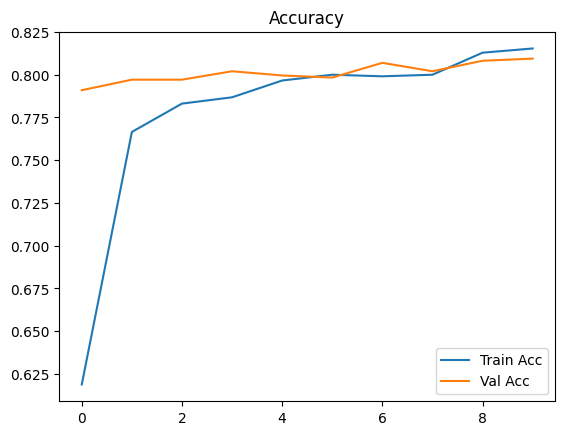

26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 452ms/step
[[  0  23   1]
 [  0 626  20]
 [  0 137   6]]
                       precision    recall  f1-score   support

mask_weared_incorrect       0.00      0.00      0.00        24
            with_mask       0.80      0.97      0.87       646
         without_mask       0.22      0.04      0.07       143

             accuracy                           0.78       813
            macro avg       0.34      0.34      0.31       813
         weighted avg       0.67      0.78      0.71       813



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

# Confusion matrix
y_true = val_gen.classes
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

print(confusion_matrix(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes, target_names=val_gen.class_indices.keys()))


In [35]:
model.save('mobilenetv2_final.h5')
model.save('mobilenetv2_final.keras')

In [38]:
! ls /kaggle/working

mobilenetv2_best.keras	mobilenetv2_final.keras
mobilenetv2_final.h5	processed_faces


# MobileNetV2 full fine-tuning (top layers)

In [40]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

def build_model(base_model):
    base_model.trainable = False  # Freeze
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

base = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

# Unfreeze top layers
base.trainable = True
for layer in base.layers[:-30]:  # Freeze all except last 30 layers
    layer.trainable = False
    
model = build_model(base)

In [41]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[
        ModelCheckpoint('mobilenetv2_best.keras', save_best_only=True)
    ]
)


Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 59s 460ms/step - accuracy: 0.6445 - loss: 0.8266 - val_accuracy: 0.7983 - val_loss: 0.5592
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 42s 389ms/step - accuracy: 0.7742 - loss: 0.6165 - val_accuracy: 0.7970 - val_loss: 0.5595
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 399ms/step - accuracy: 0.7817 - loss: 0.6033 - val_accuracy: 0.7995 - val_loss: 0.5257
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 407ms/step - accuracy: 0.7954 - loss: 0.5646 - val_accuracy: 0.8020 - val_loss: 0.5094
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 403ms/step - accuracy: 0.8030 - loss: 0.5378 - val_accuracy: 0.8032 - val_loss: 0.5118
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 402ms/step - accuracy: 0.7965 - loss: 0.5667 - val_accuracy: 0.8093 - val_loss: 0.4885
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 397ms/step - accuracy: 0.7987 - loss: 0.5521 - val_accuracy: 0.8118 - val_loss: 0.4856
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 42s 393ms/step - accuracy: 0.8001 - loss: 0

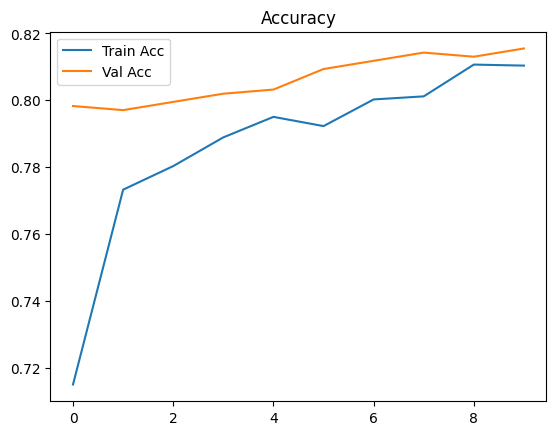

26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 433ms/step
[[  0  23   1]
 [  0 617  29]
 [  0 133  10]]
                       precision    recall  f1-score   support

mask_weared_incorrect       0.00      0.00      0.00        24
            with_mask       0.80      0.96      0.87       646
         without_mask       0.25      0.07      0.11       143

             accuracy                           0.77       813
            macro avg       0.35      0.34      0.33       813
         weighted avg       0.68      0.77      0.71       813



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

# Confusion matrix
y_true = val_gen.classes
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

print(confusion_matrix(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes, target_names=val_gen.class_indices.keys()))


In [43]:
model.save('mobilenetv2_toplayers_final.h5')
model.save('mobilenetv2_toplayers_final.keras')

# ResNet50

In [44]:
from tensorflow.keras.applications import ResNet50

In [45]:
def build_model(base_model):
    base_model.trainable = False  # Freeze
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

base = ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
model = build_model(base)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [46]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[
        ModelCheckpoint('resnet50_best.keras', save_best_only=True)
    ]
)


Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 71s 521ms/step - accuracy: 0.5357 - loss: 1.0206 - val_accuracy: 0.7946 - val_loss: 0.6207
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 404ms/step - accuracy: 0.7734 - loss: 0.6799 - val_accuracy: 0.7946 - val_loss: 0.6003
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 405ms/step - accuracy: 0.7800 - loss: 0.6635 - val_accuracy: 0.7946 - val_loss: 0.5952
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 397ms/step - accuracy: 0.7689 - loss: 0.6592 - val_accuracy: 0.7946 - val_loss: 0.5987
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 403ms/step - accuracy: 0.7876 - loss: 0.6500 - val_accuracy: 0.7946 - val_loss: 0.5906
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 405ms/step - accuracy: 0.7749 - loss: 0.6593 - val_accuracy: 0.7946 - val_loss: 0.5897
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 404ms/step - accuracy: 0.7943 - loss: 0.6263 - val_accuracy: 0.7946 - val_loss: 0.5884
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 396ms/step - accuracy: 0.7975 - loss: 0

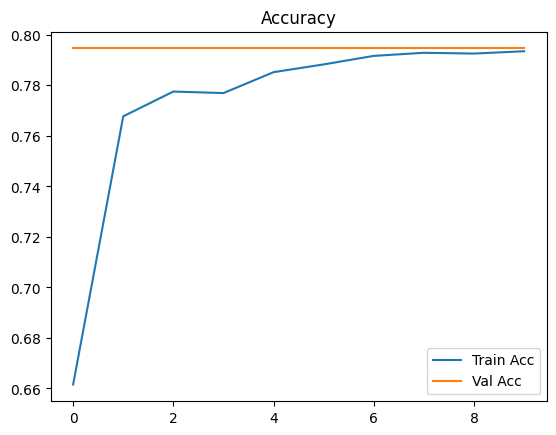

26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 530ms/step
[[  0  24   0]
 [  0 646   0]
 [  0 143   0]]
                       precision    recall  f1-score   support

mask_weared_incorrect       0.00      0.00      0.00        24
            with_mask       0.79      1.00      0.89       646
         without_mask       0.00      0.00      0.00       143

             accuracy                           0.79       813
            macro avg       0.26      0.33      0.30       813
         weighted avg       0.63      0.79      0.70       813



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

# Confusion matrix
y_true = val_gen.classes
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

print(confusion_matrix(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes, target_names=val_gen.class_indices.keys()))


In [48]:
model.save('resnet50_final.h5')
model.save('resnet50_final.keras')

# ResNet50 full fine-tuning (top layers)

In [49]:
def build_model(base_model):
    base_model.trainable = False  # Freeze
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

base = ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')


base.trainable = True
for layer in base.layers[:-30]:  
    layer.trainable = False

model = build_model(base)

In [50]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[
        ModelCheckpoint('resnet50_best.keras', save_best_only=True)
    ]
)


Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 67s 500ms/step - accuracy: 0.4155 - loss: 1.0866 - val_accuracy: 0.7946 - val_loss: 0.5952
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 412ms/step - accuracy: 0.8012 - loss: 0.6075 - val_accuracy: 0.7946 - val_loss: 0.5892
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 399ms/step - accuracy: 0.7895 - loss: 0.6417 - val_accuracy: 0.7946 - val_loss: 0.5896
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 400ms/step - accuracy: 0.8012 - loss: 0.6116 - val_accuracy: 0.7946 - val_loss: 0.5895
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 412ms/step - accuracy: 0.8207 - loss: 0.5707 - val_accuracy: 0.7946 - val_loss: 0.5889
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 407ms/step - accuracy: 0.7963 - loss: 0.6164 - val_accuracy: 0.7946 - val_loss: 0.5885
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 45s 415ms/step - accuracy: 0.7959 - loss: 0.6184 - val_accuracy: 0.7946 - val_loss: 0.5881
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 406ms/step - accuracy: 0.7991 - loss: 0

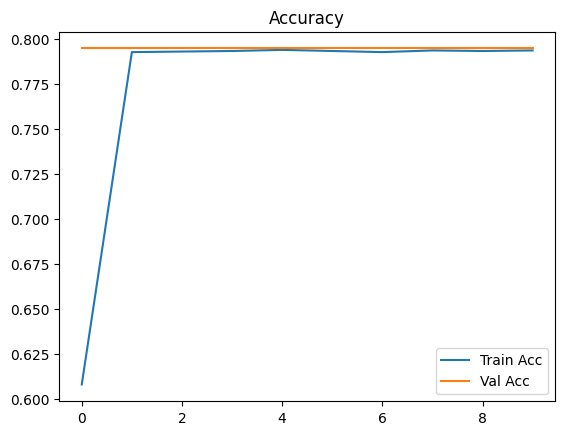

26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 533ms/step
[[  0  24   0]
 [  0 646   0]
 [  0 143   0]]
                       precision    recall  f1-score   support

mask_weared_incorrect       0.00      0.00      0.00        24
            with_mask       0.79      1.00      0.89       646
         without_mask       0.00      0.00      0.00       143

             accuracy                           0.79       813
            macro avg       0.26      0.33      0.30       813
         weighted avg       0.63      0.79      0.70       813



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

# Confusion matrix
y_true = val_gen.classes
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

print(confusion_matrix(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes, target_names=val_gen.class_indices.keys()))


In [52]:
model.save('resnet50_toplayers_final.h5')
model.save('resnet50_toplayers_final.keras')

# EfficientNetB0

In [53]:
from tensorflow.keras.applications import EfficientNetB0

In [54]:
def build_model(base_model):
    base_model.trainable = False  # Freeze
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

base = ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

model = build_model(base)

In [55]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[
        ModelCheckpoint('efficientnetB0_best.keras', save_best_only=True)
    ]
)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 68s 502ms/step - accuracy: 0.7771 - loss: 0.7306 - val_accuracy: 0.7946 - val_loss: 0.5963
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 412ms/step - accuracy: 0.7660 - loss: 0.6793 - val_accuracy: 0.7946 - val_loss: 0.5936
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 45s 415ms/step - accuracy: 0.7801 - loss: 0.6410 - val_accuracy: 0.7946 - val_loss: 0.5932
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 412ms/step - accuracy: 0.7914 - loss: 0.6172 - val_accuracy: 0.7946 - val_loss: 0.5922
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 45s 416ms/step - accuracy: 0.7942 - loss: 0.6114 - val_accuracy: 0.7946 - val_loss: 0.5907
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 407ms/step - accuracy: 0.8009 - loss: 0.6081 - val_accuracy: 0.7946 - val_loss: 0.5896
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 407ms/step - accuracy: 0.7829 - loss: 0.6425 - val_accuracy: 0.7946 - val_loss: 0.5885
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 407ms/step - accuracy: 0.8048 - loss: 0

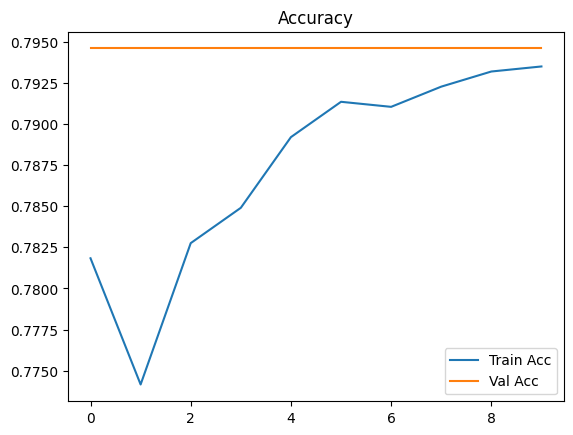

26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 527ms/step
[[  0  24   0]
 [  0 646   0]
 [  0 143   0]]
                       precision    recall  f1-score   support

mask_weared_incorrect       0.00      0.00      0.00        24
            with_mask       0.79      1.00      0.89       646
         without_mask       0.00      0.00      0.00       143

             accuracy                           0.79       813
            macro avg       0.26      0.33      0.30       813
         weighted avg       0.63      0.79      0.70       813



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

# Confusion matrix
y_true = val_gen.classes
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

print(confusion_matrix(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes, target_names=val_gen.class_indices.keys()))


In [ ]:
model.save('efficientnetB0_final.h5')
model.save('efficientnetB0_final.keras')

# EfficientNetB0 full fine-tuning (top layers)

In [ ]:
def build_model(base_model):
    base_model.trainable = False  # Freeze
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

base = ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

# Unfreeze top layers
base.trainable = True
for layer in base.layers[:-30]:  # Freeze all except last 30 layers
    layer.trainable = False

model = build_model(base)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[
        ModelCheckpoint('efficientnetB0_best.keras', save_best_only=True)
    ]
)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 66s 493ms/step - accuracy: 0.2456 - loss: 1.4733 - val_accuracy: 0.7946 - val_loss: 0.6657
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 402ms/step - accuracy: 0.7855 - loss: 0.6947 - val_accuracy: 0.7946 - val_loss: 0.5974
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 407ms/step - accuracy: 0.8026 - loss: 0.6158 - val_accuracy: 0.7946 - val_loss: 0.5885
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 400ms/step - accuracy: 0.7975 - loss: 0.6060 - val_accuracy: 0.7946 - val_loss: 0.5869
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 42s 394ms/step - accuracy: 0.7802 - loss: 0.6394 - val_accuracy: 0.7946 - val_loss: 0.5895
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 397ms/step - accuracy: 0.7810 - loss: 0.6340 - val_accuracy: 0.7946 - val_loss: 0.5888
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 395ms/step - accuracy: 0.7971 - loss: 0.5970 - val_accuracy: 0.7946 - val_loss: 0.5879
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 399ms/step - accuracy: 0.7953 - loss: 0

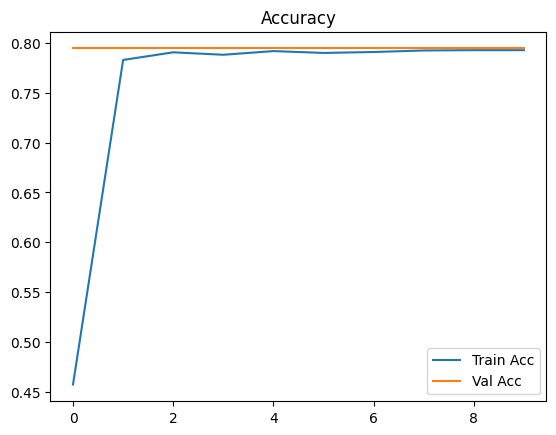

26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 535ms/step
[[  0  24   0]
 [  0 646   0]
 [  0 143   0]]
                       precision    recall  f1-score   support

mask_weared_incorrect       0.00      0.00      0.00        24
            with_mask       0.79      1.00      0.89       646
         without_mask       0.00      0.00      0.00       143

             accuracy                           0.79       813
            macro avg       0.26      0.33      0.30       813
         weighted avg       0.63      0.79      0.70       813



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

# Confusion matrix
y_true = val_gen.classes
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

print(confusion_matrix(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes, target_names=val_gen.class_indices.keys()))


In [62]:
model.save('efficientnetB0_toplayers_final.h5')
model.save('efficientnetB0_toplayers_final.keras')

In [63]:
! ls /kaggle/working

efficientnetB0_best.keras	      mobilenetv2_toplayers_final.h5
efficientnetB0_final.h5		      mobilenetv2_toplayers_final.keras
efficientnetB0_final.keras	      processed_faces
efficientnetB0_toplayers_final.h5     resnet50_best.keras
efficientnetB0_toplayers_final.keras  resnet50_final.h5
mobilenetv2_best.keras		      resnet50_final.keras
mobilenetv2_final.h5		      resnet50_toplayers_final.h5
mobilenetv2_final.keras		      resnet50_toplayers_final.keras


In [64]:
!zip -r model_weights.zip /kaggle/working/*.h5 /kaggle/working/*.keras

  adding: kaggle/working/efficientnetB0_final.h5 (deflated 8%)
  adding: kaggle/working/efficientnetB0_toplayers_final.h5 (deflated 8%)
  adding: kaggle/working/mobilenetv2_final.h5 (deflated 12%)
  adding: kaggle/working/mobilenetv2_toplayers_final.h5 (deflated 12%)
  adding: kaggle/working/resnet50_final.h5 (deflated 8%)
  adding: kaggle/working/resnet50_toplayers_final.h5 (deflated 8%)
  adding: kaggle/working/efficientnetB0_best.keras (deflated 8%)
  adding: kaggle/working/efficientnetB0_final.keras (deflated 8%)
  adding: kaggle/working/efficientnetB0_toplayers_final.keras (deflated 8%)
  adding: kaggle/working/mobilenetv2_best.keras (deflated 12%)
  adding: kaggle/working/mobilenetv2_final.keras (deflated 12%)
  adding: kaggle/working/mobilenetv2_toplayers_final.keras (deflated 12%)
  adding: kaggle/working/resnet50_best.keras (deflated 8%)
  adding: kaggle/working/resnet50_final.keras (deflated 8%)
  adding: kaggle/working/resnet50_toplayers_final.keras (deflated 8%)
